In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from board_detection import homography_dataset
from board_detection.homomography_network import HomographyNet
from board_detection.homomography_training import extract_homography_prediction
from board_detection.homomography_training import load_dataset
from board_detection.homomography_training import train_model
from board_detection.homomography_training import calculate_test_loss
from board_detection.homography_loss import PhotometricLoss

In [ ]:
model_resolution = 128
dataset_resolution = 512

input_transform_pipeline = transforms.Compose([
    transforms.Resize((model_resolution, model_resolution)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor()
])

label_transform_pipeline = transforms.Compose([
    homography_dataset.HomographyOutputTransform((dataset_resolution, dataset_resolution), (model_resolution, model_resolution)),
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)), 
    transforms.Lambda(lambda x: torch.flatten(x))
])

json_path = "pre_processing/data/output/perspective_distorted_boards/bbox_coordinates.json"
img_dir = "pre_processing/data/output/perspective_distorted_boards"

dataset = load_dataset(json_path, img_dir, input_transform_pipeline, label_transform_pipeline)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

learning_rate = 0.001
num_epochs = 105
model = HomographyNet((1, model_resolution, model_resolution), 9) # cuz the matrix is flat 3 x 3
# criterion = nn.MSELoss()
criterion = PhotometricLoss(model)
device = "cuda"
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
save_path = "runs/models/homomography_hybrid_128_model.pth"
# save_path = None
resume_path =  "runs/models/homomography_hybrid_128_model.pth"
# resume_path = None


train_losses, val_losses, best_model_state_dict = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path, resume_path)
model.eval()
test_loss = calculate_test_loss(model, test_loader, criterion, device)

Resuming training from epoch 105


100%|██████████| 188/188 [00:14<00:00, 12.64it/s]


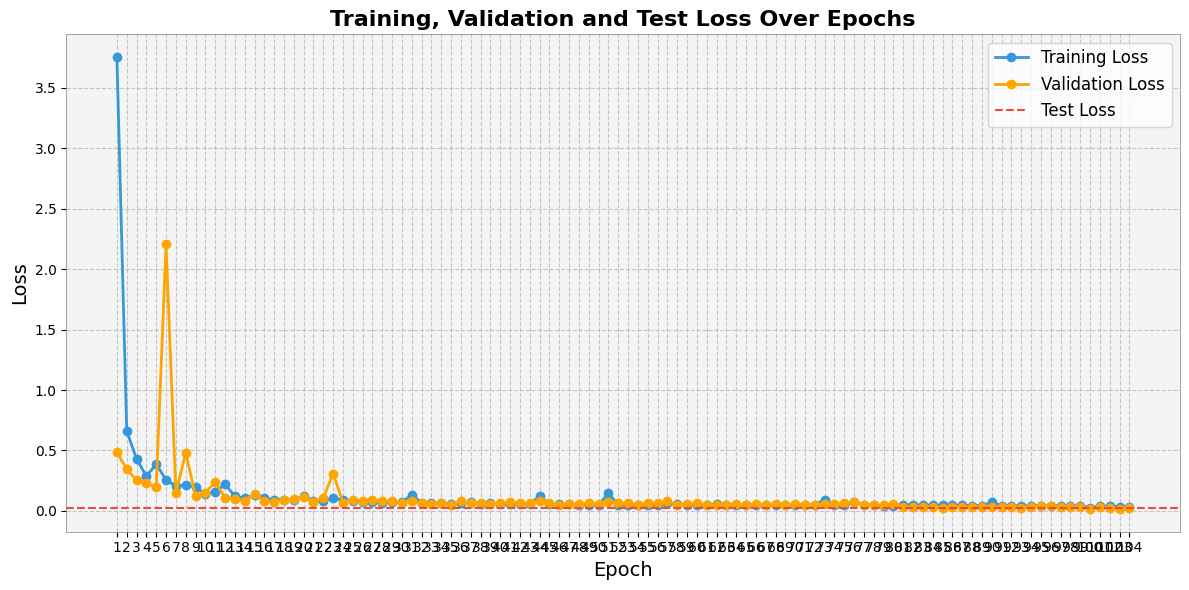

In [13]:
from visualization import show_loss 
show_loss.show_train_test_loss(train_losses, val_losses, test_loss, num_epochs - 1 )

Random image path: pre_processing/data/output/perspective_distorted_boards/canvas_image_8323.png


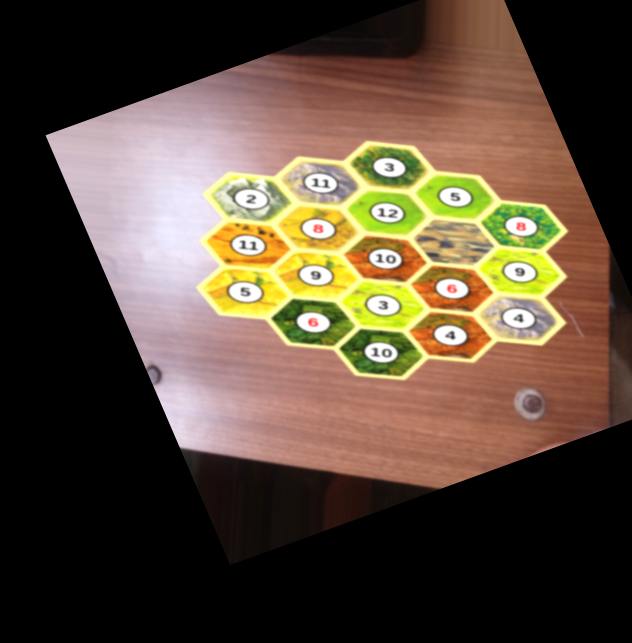

In [7]:
import os
import random

from board_detection import perspective_correct_image

data_dir = "pre_processing/data/output/perspective_distorted_boards"

# Get a list of all files in the directory
image_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
random_image = random.choice(image_files)
random_image_path = os.path.join(data_dir, random_image)

print("Random image path:", random_image_path)

perspective_correct_image.perspective_correct_image(random_image_path, "runs/models/homomography_hybrid_128_model.pth")

Random image path: pre_processing/data/output/perspective_distorted_boards/canvas_image_5912.png

0: 640x608 1 Catan-Board, 37.6ms
Speed: 7.7ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


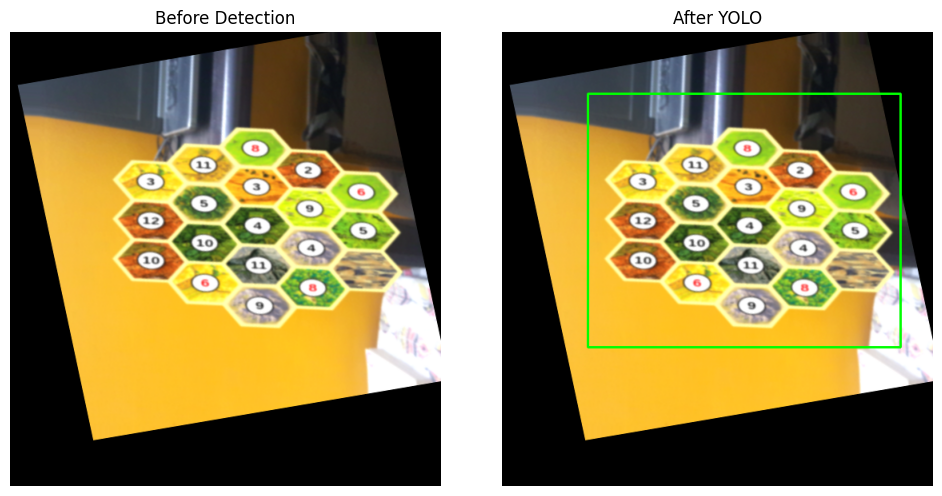

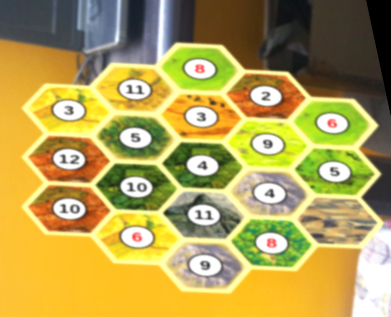

In [ ]:
from ultralytics import YOLO
from PIL import Image
from board_detection.yolo_extraction import board_detection_step

# Setup
data_dir = "data/full/perspective_distorted_boards_sample/images"
model_path = "board_detection/data/output/train4/weights/best.pt"  

# Load model
model_yolo = YOLO(model_path)
data_dir = "pre_processing/data/output/perspective_distorted_boards"

# Get a list of all files in the directory
image_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
random_image = random.choice(image_files)
random_image_path = os.path.join(data_dir, random_image)

print("Random image path:", random_image_path)

image = Image.open(random_image_path).convert("RGB")
class_id = 0
image = perspective_correct_image.perspective_correct_image(image, "runs/models/homomography_hybrid_128_model.pth", path_or_img="img")
bbox = board_detection_step(image, model_yolo, class_id, show_results=True, ground_truth_bbox=None)
bbox = list(map(int, bbox))
cropped_image = image.crop(bbox)
cropped_image